# Sentiment analysis

Questo laboratorio si basa sulla sentiment analysis: vogliamo essere in grado di valutare se una recenzione è positiva o negativa usando come informazioni il dataset *Cornell Rotten Tomatoes movie review dataset*.

Per fare questo useremo il modello Distilbert, una semplificazione di BERT.

---
# Import & Setting

In [1]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import evaluate
import wandb
from datasets import load_dataset, get_dataset_split_names
from transformers import AutoTokenizer, AutoModel, pipeline, DataCollatorWithPadding, TrainingArguments, Trainer, AutoModelForSequenceClassification
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
from peft import get_peft_model, LoraConfig, TaskType

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

---
# Analisi dataset

Eseguiamo adesso una prima analisi del dataset in questione.

In [2]:
ds_id = 'cornell-movie-review-data/rotten_tomatoes'
print(get_dataset_split_names(ds_id))
ds_train = load_dataset(ds_id, split='train')
ds_val = load_dataset(ds_id, split='validation')
ds_test = load_dataset(ds_id, split='test')


['train', 'validation', 'test']


In [3]:
print(ds_train)
print(ds_val)
print(ds_test)
print('\n')
print(f'- Freatures: {ds_train.features}')
print(f'- Possibili valutazioni: {np.unique(ds_train["label"])}')
print(f'- Elemento 0: {ds_train[0]}')
print(f'- Elemento 5756: {ds_train[5756]}')


Dataset({
    features: ['text', 'label'],
    num_rows: 8530
})
Dataset({
    features: ['text', 'label'],
    num_rows: 1066
})
Dataset({
    features: ['text', 'label'],
    num_rows: 1066
})


- Freatures: {'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['neg', 'pos'], id=None)}
- Possibili valutazioni: [0 1]
- Elemento 0: {'text': 'the rock is destined to be the 21st century\'s new " conan " and that he\'s going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .', 'label': 1}
- Elemento 5756: {'text': 'bottom-rung new jack city wannabe .', 'label': 0}


**Analisi**

Il dataset rappresenta una serie di recenzioni con l'etichetta ad essa assegnata.
- Vediamo che il trainset ha 8530 istanze, mentre il validation e test set ahnno entrambe 1066. Si tratta quindi di una divisione 80%, 10% e 10% rispettivaente.
- Possiamo notare che ad ogni recensizone è associata un'etichetta: 0 significa relazione negativa, 1 inevce relazione positiva. Questo ci è chiaro anche analizzando il primo e uno degli ultimi esempi del dataset.

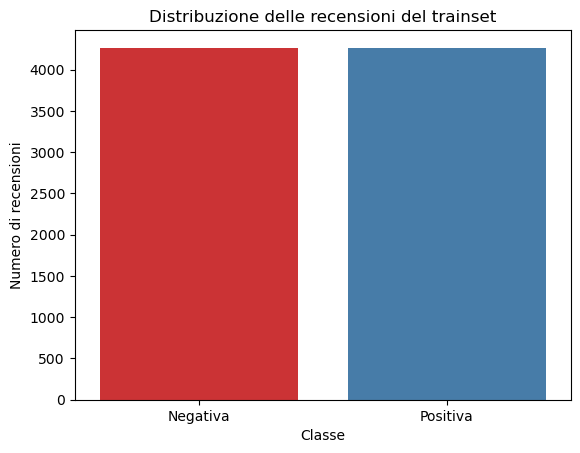

In [4]:
labels = ds_train['label']
palette = sns.color_palette('Set1', 2)
plt.figure()
plt.title("Distribuzione delle recensioni del trainset")
plt.xlabel('Classe')
plt.ylabel('Numero di recensioni')
plt.xticks([0, 1], ['Negativa', 'Positiva'])
sns.countplot(x=labels, hue=labels, palette=palette, legend=False)
plt.show()

# if(false):
#   percorso_file = dowload_path + 'distribuzione MNIST.pdf'
#   plt.savefig(percorso_file, dpi=300, bbox_inches='tight')

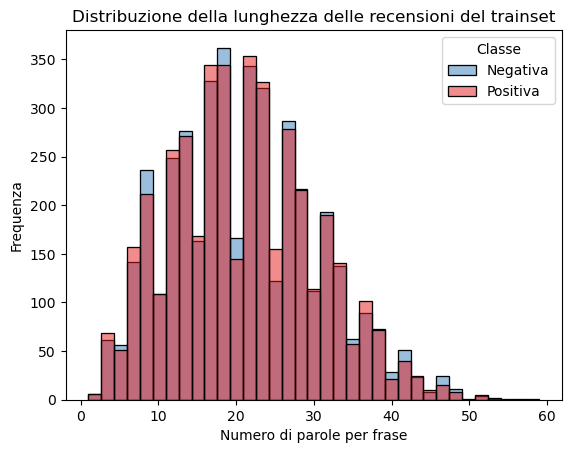

In [5]:
review_lengths = [len(text.split()) for text in ds_train['text']]
palette = sns.color_palette('Set1', 2)
plt.figure()
sns.histplot(x=review_lengths, hue=ds_train['label'], bins=35, palette=palette, kde=False)
plt.title("Distribuzione della lunghezza delle recensioni del trainset")
plt.xlabel('Numero di parole per frase')
plt.ylabel('Frequenza')
plt.legend(title='Classe', labels=['Negativa', 'Positiva'])
plt.show()

# if(false):
#   percorso_file = dowload_path + 'distribuzione MNIST.pdf'
#   plt.savefig(percorso_file, dpi=300, bbox_inches='tight')

**Analisi**

Dai due grafici sopra:
- Possiamo vedere che le recensioni sono perfettamente bilanciate tra negative e positive.
- È compicato stabile una relazione tra lunghezza delle recensioni e la loro qualità. Possiamo però notare che le recensioni più corte di 5/6 parle e più lunghe di 40 sono poche.

---
# Distilbert e Tokenizer

Esloriamo adesso il modello che andremmo ad utilizzare: Distilbert, un modello addestrato tramite self-supervised learning con BERT come teacher.

In [6]:
model_id = 'distilbert/distilbert-base-uncased'
model = AutoModel.from_pretrained(model_id)
tokenizer = AutoTokenizer.from_pretrained(model_id)

In [7]:
model

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): DistilBertSdpaAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): L

**Analisi**

Vediamo la struttura del modello Distilbert:
- Il blocco di `Embedding` serve per fare l'emebedding: in pratica prende per ogni token viene prodotto un vettore di dimensione 768, applicando la normalizzazione e il dropout.
- Abbiamo poi sei blocchi `Transformers` di self attention.
- Il modello produce per ogni token in input una sua rappresentazione, cioè per ogni token un vettore di 748 elementi.
- Con le CNN siamo abituati a lavorare con i moduli `Sequential`, qua invece ci sono moduli `ModuleList` e il motivo probabilmente è dovuto all'implementazione: se dobbiamo fare qualcosa tra un layer e l'altro, iterare su un ModuleList ci semplifica la vita.

In [8]:
tokenizer

DistilBertTokenizerFast(name_or_path='distilbert/distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [9]:
review = ds_train[0]['text']
print(f'- Review: {review}')
tokenization = tokenizer.tokenize(review)
print(f'- Tokenization: {tokenization}')
encoding = tokenizer.convert_tokens_to_ids(tokenization)
print(f'- Encoding: {encoding}')

- Review: the rock is destined to be the 21st century's new " conan " and that he's going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .
- Tokenization: ['the', 'rock', 'is', 'destined', 'to', 'be', 'the', '21st', 'century', "'", 's', 'new', '"', 'conan', '"', 'and', 'that', 'he', "'", 's', 'going', 'to', 'make', 'a', 'splash', 'even', 'greater', 'than', 'arnold', 'schwarz', '##ene', '##gger', ',', 'jean', '-', 'cl', '##aud', 'van', 'dam', '##me', 'or', 'steven', 'sega', '##l', '.']
- Encoding: [1996, 2600, 2003, 16036, 2000, 2022, 1996, 7398, 2301, 1005, 1055, 2047, 1000, 16608, 1000, 1998, 2008, 2002, 1005, 1055, 2183, 2000, 2191, 1037, 17624, 2130, 3618, 2084, 7779, 29058, 8625, 13327, 1010, 3744, 1011, 18856, 19513, 3158, 5477, 4168, 2030, 7112, 16562, 2140, 1012]


**Analisi**

In generale un tokenizer serve per convertire una stringa in token ID che poi sono usati dal modello. A seconda delle regole del modello, il tokenizer divide il testo in token (tokenizzazione) e poi li converti in ID usando un dato vocabolario (codifica); la dimensione del vocabolario possiamo vedere dal tokenizer essere di 30522.

Fondamentali sono i token aggiunti da tokenizer come ad esempio:
- `CLS (101)`: Serve per compiti di classificazione come la sentiment analysis.
- `SEP (102)`: Serve per compiti dove si devono analizzare più frasi. In pratica separa le frasi o parti di esse.

In [10]:
reviews = ds_train[:2]['text']
print(f'- Completo con tensore e padding:\n {tokenizer(reviews, padding=True, return_tensors="pt")}')

- Completo con tensore e padding:
 {'input_ids': tensor([[  101,  1996,  2600,  2003, 16036,  2000,  2022,  1996,  7398,  2301,
          1005,  1055,  2047,  1000, 16608,  1000,  1998,  2008,  2002,  1005,
          1055,  2183,  2000,  2191,  1037, 17624,  2130,  3618,  2084,  7779,
         29058,  8625, 13327,  1010,  3744,  1011, 18856, 19513,  3158,  5477,
          4168,  2030,  7112, 16562,  2140,  1012,   102,     0,     0,     0,
             0,     0],
        [  101,  1996,  9882,  2135,  9603, 13633,  1997,  1000,  1996,  2935,
          1997,  1996,  7635,  1000, 11544,  2003,  2061,  4121,  2008,  1037,
          5930,  1997,  2616,  3685, 23613,  6235,  2522,  1011,  3213,  1013,
          2472,  2848,  4027,  1005,  1055,  4423,  4432,  1997,  1046,  1012,
          1054,  1012,  1054,  1012, 23602,  1005,  1055,  2690,  1011,  3011,
          1012,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 

**Analisi**

Quando lavoriamo con più frasi, come più recensioni, è fondamentale renderle della stessa lunghezza; per questo motivo vengono aggiunti dei token fittizzi. Il compito dell'attention mask è quello rendere noto al modello quali token sono reali (1) e quali di padding (0).

In [11]:
reviews = ds_train[:2]['text']
input = tokenizer(reviews, padding=True, return_tensors='pt')
output = model(**input)
print(f'- Output:\n {output}')
print(f'- Last hidden state size: {output.last_hidden_state.size()}')

- Output:
 BaseModelOutput(last_hidden_state=tensor([[[-0.0332, -0.0168,  0.0194,  ...,  0.0476,  0.5834,  0.3036],
         [-0.0235, -0.0555, -0.3638,  ...,  0.1877,  0.5781, -0.1577],
         [-0.0516, -0.1014, -0.1511,  ...,  0.1503,  0.2649, -0.1575],
         ...,
         [ 0.3688, -0.1147,  0.8428,  ..., -0.0708, -0.0178, -0.2516],
         [ 0.0654, -0.0206,  0.1889,  ...,  0.1159,  0.2323, -0.2404],
         [ 0.0373, -0.0104,  0.1203,  ...,  0.1049,  0.2852, -0.3035]],

        [[-0.2062, -0.0490, -0.4036,  ..., -0.1186,  0.6141,  0.3919],
         [-0.4361, -0.1647, -0.3533,  ...,  0.1086,  0.9478, -0.0272],
         [-0.1164,  0.1690,  0.2698,  ..., -0.1971,  0.4372,  0.2527],
         ...,
         [-0.2341,  0.4810, -0.2634,  ..., -0.3397,  0.2567,  0.1274],
         [ 0.7139,  0.0574, -0.3260,  ...,  0.2041, -0.3800, -0.3343],
         [ 0.5649,  0.2806, -0.0295,  ...,  0.1297, -0.3160, -0.1874]]],
       grad_fn=<NativeLayerNormBackward0>), hidden_states=None, attenti

**Analisi**

Il risultato fondamentale è `last_hidden_layer`, cioè il risultato della funzione forward del modello. Contiene la rappresentazione di tutti i token dove che l'input è tramite il modello.

Possiamo vedere che ha infatti una precisa size: 2 frasi, 52 parole per frasi (alla frase più corta sono stati aggiunti token di padding) e 786 è la dimensione.

In [12]:
input = tokenizer(ds_train[0]['text'], return_tensors='pt')
reviews_dec = tokenizer.decode(input['input_ids'][0])
print(reviews)
print(reviews_dec)

['the rock is destined to be the 21st century\'s new " conan " and that he\'s going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .', 'the gorgeously elaborate continuation of " the lord of the rings " trilogy is so huge that a column of words cannot adequately describe co-writer/director peter jackson\'s expanded vision of j . r . r . tolkien\'s middle-earth .']
[CLS] the rock is destined to be the 21st century ' s new " conan " and that he ' s going to make a splash even greater than arnold schwarzenegger, jean - claud van damme or steven segal. [SEP]


**Analisi**

Vediamo come decoficando e tornando alla recensione ci sono delle differenze. Questo è dovuto al processo di tokenizzazione: la rappresentazione dei token viene fatta secondo le regole del modello.

Osserviamo che è stato anche incluso i due token speciali `CLS` e `SEP`.

---
# Baseline

Cerchiamo di stabilire una baseline da cui poi milgiorare il modello. Per questo compito è stato usato una SVM.

In [13]:
model.to(device)
extractor = pipeline('feature-extraction', model=model, tokenizer=tokenizer)
def extract_features(ds):
    texts = ds['text']
    feats = extractor(texts, padding=True, return_tensors='pt')
    cls_embeddings = [feat[0,0] for feat in feats]
    return torch.vstack(cls_embeddings)

def plot_confusion_matrix(y_true, y_pred, title):
    matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4,3))
    plt.title('Matrice di confusione - ' + title)
    plt.xlabel('Classi predette')
    plt.ylabel('Classi vere')
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Reds',
                xticklabels=['negative', 'positive'],
                yticklabels=['negative', 'positive'])
    plt.show()

Device set to use mps:0


In [14]:
if(False):
    Xs_train = extract_features(ds_train)
    ys_train = ds_train['label']
    Xs_val = extract_features(ds_val)
    ys_val = ds_val['label']
    Xs_test = extract_features(ds_test)
    ys_test = ds_test['label']

    print(f'- Dimensione train set: {Xs_train.size()}')
    print(f'- Dimensione validation set: {Xs_val.size()}')
    print(f'- Dimensione test set: {Xs_test.size()}')   

**Analisi**

Per osservare che la features extraction sia andata bene possiamo visualizzare la dimensionalità dei tensori di output.

Se andiamo a rivedere la dimensionalità di `ds_train` vediamo che aveva 8530 recensioni; stesso numero di elementi li ha il tensore `Xs_train`. In pratica adesso ogni istanza contiene solo il token `CLS e il relativo vettore di 768.

In [15]:
if(False):
    svc = LinearSVC()
    svc.fit(Xs_train, ys_train)
    pred_val = svc.predict(Xs_val)
    pred_test = svc.predict(Xs_test)
    print("- Validation set")
    print(classification_report(ys_val, pred_val, target_names=['negative', 'positive']))
    plot_confusion_matrix(ys_val, pred_val, title='Validation Set')
    print("- Test set")
    print(classification_report(ys_test, pred_test, target_names=['negative', 'positive']))
    plot_confusion_matrix(ys_test, pred_test, title='Test Set')

**Analisi**

Abbiamo raggiunto una baseline dell'80% con SVM. Probabilmente se usavamo un MLP il risulato sarebbe stato migliore, ma cerchiamo di migliorarlo tramite il fine tunning.

----
# Full fine-tuning
Cerchiamo adesso di migliorare le performance della baseline aggiornando i pesi del modello facendo un full fine tuning.

In [16]:
def my_tokenize(ds):
    return tokenizer(ds['text'], padding=True, return_tensors='pt')

In [17]:
tokenized_train = ds_train.map(my_tokenize, batched=True)
tokenized_val = ds_val.map(my_tokenize, batched=True)
tokenized_test = ds_test.map(my_tokenize, batched=True)

In [18]:
tokenized_train[0].keys()

dict_keys(['text', 'label', 'input_ids', 'attention_mask'])

**Analisi**

L'idea è quella di arricchire il dataset in modo che non contenga solo il testo e l'etichetta, ma anche le informazioni provenienti dal tokenizer. Questo è valido perché durante il fine tuning il tokenizer non cambia mai e possiamo introdurre le sue informazioni statiche nel dataset.

Abbiamo quindi ottenuto un nuovo dataset tokenizzato, dove ad ogni esempio associamo la relazione, l'etichetta, gli ID dei token e l'attention mask.

In [19]:
model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=2)
model = model.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**Analisi**

In questo modo quelo che facciamo è aggiungere un classificatore alla fine di Distilbert, cioè alla fine dei layer `Transformer`.

Il messaggio che vediamo ci dice che i pesi di questo classificatore non sono ancora allenati. È un modo utile anche per non dimenticarsi di addestrarlo.

In [20]:
def metrics(eval_pred):
    accuracy = evaluate.load('accuracy')
    f1 = evaluate.load('f1')
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    acc = accuracy.compute(predictions=predictions, references=labels)['accuracy']
    f1 = f1.compute(predictions=predictions, references=labels)['f1']
    return {'accuracy': acc, 'f1': f1}

def training(model, run_name, lr=2e-5, epochs=5):
    training_args=TrainingArguments(
        output_dir="./output",
        run_name=run_name,
        learning_rate=lr,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=32,
        num_train_epochs=epochs,
        save_strategy="epoch",
        do_eval=True,
        eval_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        greater_is_better=True
    )
    trainer=Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_val,
        data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
        compute_metrics=metrics
    )
    wandb.init(project='Distilbert', name=run_name)
    trainer.train()
    trainer.evaluate()
    preds = trainer.predict(tokenized_test)
    ys_test = preds.label_ids
    pred_test = np.argmax(preds.predictions, axis=1)
    print('- Risultati sul test set:')
    print(classification_report(ys_test, pred_test, target_names=['negative', 'positive']))
    wandb.finish()

**Analisi**

Vediamo le cose principali del metodo `training`:
- Il DataCollector è utile, dato un tokenizer, per aggiungere il padding in modo dinamico agli input ricevuti.
- `TrainingArguments` definisce gli argomenti per l'addeestramento. Ci sono aspetti, come il learning rate, il batch_size e il nome del run, che possiamo dare per scontati. La cosa più interessante è come specifica il comportamento del `Trainer`: ogni epoca l'addestramento si ferma e valuta il modello; alla fine dell'addestramento verranno caricati i pesi del miglior modello sulla base dell'accuracy; è stata scelta questa metrica perchè il dataset è ben bilanciato, ma in alternativa si potrebbe usare la metrica f1.
- `Trainer`definisce invece l'addestramento vero e proprio e si basa sugli argomenti già deifniti.
- Si usa infine wandb per loggare le metriche.

In [21]:
if(False):
    training(model, 'full fine tuning')

**Analisi**

Quello che abbiamo fatto fino a questo momento è aggiornare i pesi di Distilbert a partire da quelli pre addestrati e addestarre da zero i pesi del calssificatore aggiunto alla fine, cioè full fine tuning.

Come si può notare è molto facile fare overfitting: già infatti dalla terza epoca si vede che l'acuracy rimane abbastanza invariata mentre la loss sul train set diminuisce, quella sul validation set aumenta, segno appunto che dovremmo stopparare l'addestramento perche stiamo overffintando.

Se valutiamo le prestazioni sul test set possiamo notare come abbiamo fatto meglio della baseline, raggiungendo un 85% dall'80% della baseline. Cerchiamo nel seguito di migliorare ancora con accorgimenti più tecnici.

---
# Congelare Distilbert


In [22]:
if(False):
    model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=2)
    for param in model.base_model.parameters():
        param.requires_grad = False
    model = model.to(device)
    training(model, 'classifier fine tuning', epochs=10)

**Analisi**

Quello che abbiamo fatto fare fine tuning solo della testa, cioè del classificatore, congelando i pesi del backbone Distilbert. Si può osservare die risultati peggiori anche della baseline, con puntiggi di accuracy di 78% contro l'80%.

Nel seguito cerchiamo di migliorare le prestazioni usando tecnche più efficienti implementate direttamente in HuggingFace dalla libreria PEFT.

---
### LoRa fune tuning

In [23]:
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=8,
    lora_alpha=128,
    lora_dropout=0.1,
    bias="none",
    target_modules=["q_lin", "v_lin"]
)
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
model = get_peft_model(model, peft_config)
print('- Parametri allenabili:')
model.print_trainable_parameters()
print('\n')
training(model, 'lora')

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 739,586 || all params: 67,694,596 || trainable%: 1.0925


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism h

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.418608,0.811445,0.811268
2,0.482700,0.392384,0.825516,0.822180
3,0.482700,0.384089,0.832083,0.831291
4,0.394000,0.379152,0.827392,0.825427
5,0.394000,0.378819,0.826454,0.824311


- Risultati sul test set:
              precision    recall  f1-score   support

    negative       0.83      0.83      0.83       533
    positive       0.83      0.83      0.83       533

    accuracy                           0.83      1066
   macro avg       0.83      0.83      0.83      1066
weighted avg       0.83      0.83      0.83      1066



eval/accuracy,▁▆█▆▆█
eval/f1,▁▅█▆▆█
eval/loss,█▃▂▁▁▂
eval/runtime,▂█▁▃▁▃
eval/samples_per_second,▇▁█▅█▅
eval/steps_per_second,▇▁█▅█▅
test/accuracy,▁
test/f1,▁
test/loss,▁
test/runtime,▁
test/samples_per_second,▁


**Analisi**

Con questa configurazione si vede che adesso i parametri annalibili del backbone non sono zero, ma sono circa l'1,1%.

Risciamo a fare meglio del precedente fine tuning, ma ancora non a livello del full fine tuning. Cerchiamo di trovare degli iperparametri per migliorare ancora e almeno raggiungere il full fine tuning.